# Projet Kaggle
### GRIS Clément - 4 ModIA

## 1 - Pré-traitement des données

In [2]:
#Pré-processing des données
import os
import pandas as pd
from torchvision.io import read_image
import torchvision.transforms as transforms
import torch.utils.data as Data
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

class CustomImageDataset(Data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, test=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.img_files = os.listdir(img_dir)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop(size=256),
            transforms.Grayscale(),
            transforms.ToTensor(), 
            transforms.Normalize(0.5,0.5),
            transforms.RandomVerticalFlip()
        ])     #cadrage de l'image et redimensionnement
        self.target_transform = target_transform
        self.test = test

    def __len__(self):
        return len(self.img_labels) #lecture des labels

    def __getitem__(self, idx):
        if not self.test :
            img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) +'.jpg')
            image = read_image(img_path)
            label = self.img_labels.iloc[idx, 1] - 1
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else :
            img_path = os.path.join(self.img_dir, f"{4000 + idx}" +'.jpg')
            image = read_image(img_path)
            if self.transform:
                image = self.transform(image)
            return image
    
#Importation des données
data = CustomImageDataset('train.csv', "train/train")


/home/gris/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


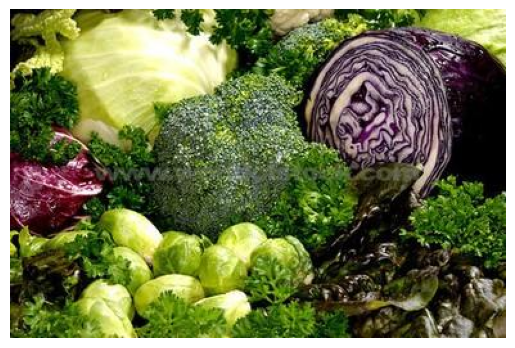

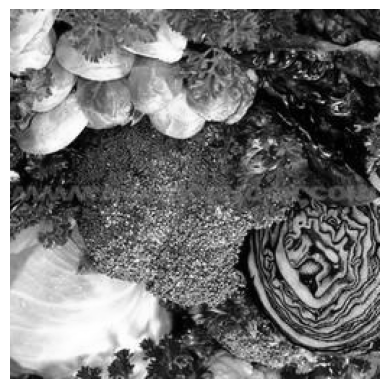

In [3]:
#Vérification que le préprocessing fonctionne
orig_img = Image.open(Path('train/train') / '7.jpg')
plt.imshow(orig_img, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(data.__getitem__(7)[0][0], cmap='gray')
plt.axis('off')
plt.show()

On prépare ici nos jeux d'entrainement et de test.

In [4]:
#Séparation des jeux de train et test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset = Data.Subset(data, range(train_size))
test_dataset = Data.Subset(data, range(train_size, train_size + test_size))

trainloader = Data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = Data.DataLoader(test_dataset, batch_size=32, shuffle=False)


## 2 - Entrainement des données avec LeNet

On définit d'abord notre modèle :

In [4]:
#Conception du modèle
import torch

class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
            torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
            torch.nn.Flatten(),
            torch.nn.Linear(16*61*61, 61),
            torch.nn.ReLU(),
            torch.nn.Linear(61, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, 4)
        )
        
    def forward(self, x):
        return self.network(x)

In [15]:
#Entrainement du modèle
from sklearn.metrics import accuracy_score
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 20

model_one = LeNet()
model_one.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_one.parameters(), lr=3e-6, weight_decay=50)
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_accuracy = []
    for inputs, label in tqdm(trainloader):
        inputs, label = inputs.to(device).float(), label.to(device)
        optimizer.zero_grad()
        outputs = model_one(inputs)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_accuracy.append(accuracy_score(label.cpu(), predicted.cpu()))
        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(np.mean(running_accuracy))

    running_loss = 0.0
    running_accuracy = []
    with torch.no_grad():
        for inputs, label in testloader:
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model_one(inputs)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs, 1)
            running_accuracy.append(accuracy_score(label.cpu(), predicted.cpu()))

            running_loss += loss.item()

    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(np.mean(running_accuracy))
    print(f'Fin epoch: {epoch + 1}/{num_epochs} - Accuracy de train: {train_accuracies[-1]:.4f} - Accuracy de test: {test_accuracies[-1]:.4f}')

print('Entraînement terminé')


100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


Fin epoch: 1/20 - Accuracy de train: 0.2331 - Accuracy de test: 0.2462


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Fin epoch: 2/20 - Accuracy de train: 0.2497 - Accuracy de test: 0.2675


100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


Fin epoch: 3/20 - Accuracy de train: 0.2559 - Accuracy de test: 0.2850


100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Fin epoch: 4/20 - Accuracy de train: 0.2847 - Accuracy de test: 0.2975


100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


Fin epoch: 5/20 - Accuracy de train: 0.2981 - Accuracy de test: 0.2988


100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


Fin epoch: 6/20 - Accuracy de train: 0.2975 - Accuracy de test: 0.3100


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Fin epoch: 7/20 - Accuracy de train: 0.3147 - Accuracy de test: 0.3300


100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Fin epoch: 8/20 - Accuracy de train: 0.3231 - Accuracy de test: 0.3400


100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Fin epoch: 9/20 - Accuracy de train: 0.3281 - Accuracy de test: 0.3525


100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Fin epoch: 10/20 - Accuracy de train: 0.3353 - Accuracy de test: 0.3350


100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Fin epoch: 11/20 - Accuracy de train: 0.3534 - Accuracy de test: 0.3563


100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


Fin epoch: 12/20 - Accuracy de train: 0.3553 - Accuracy de test: 0.3538


100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Fin epoch: 13/20 - Accuracy de train: 0.3663 - Accuracy de test: 0.3488


100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


Fin epoch: 14/20 - Accuracy de train: 0.3709 - Accuracy de test: 0.3762


100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


Fin epoch: 15/20 - Accuracy de train: 0.3684 - Accuracy de test: 0.3825


100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Fin epoch: 16/20 - Accuracy de train: 0.3738 - Accuracy de test: 0.3600


100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Fin epoch: 17/20 - Accuracy de train: 0.3819 - Accuracy de test: 0.3650


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Fin epoch: 18/20 - Accuracy de train: 0.3828 - Accuracy de test: 0.3762


100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


Fin epoch: 19/20 - Accuracy de train: 0.3744 - Accuracy de test: 0.3688


100%|██████████| 100/100 [00:06<00:00, 15.40it/s]


Fin epoch: 20/20 - Accuracy de train: 0.3853 - Accuracy de test: 0.4012
Entraînement terminé


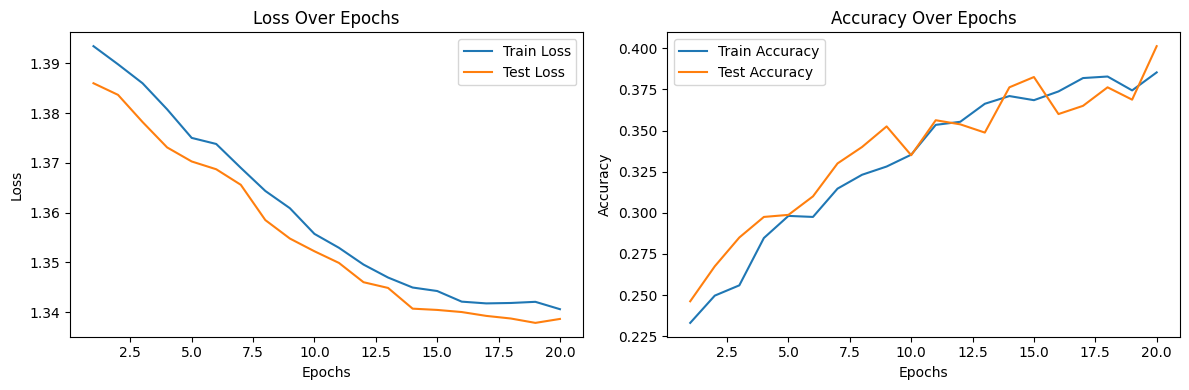

In [16]:
#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


## 3 - Entrainement des données avec AlexNet

In [10]:
# Conception du modèle

import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Flatten(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4)
            )
        
    def forward(self, x):
        return self.network(x)

In [45]:
#Entrainement du modèle
from sklearn.metrics import accuracy_score
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 100

model_one = AlexNet()
model_one.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_one.parameters(), lr=1e-4, momentum=0.5, weight_decay=0.05)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_accuracy = []
    model_one.train()
    for inputs, label in tqdm(trainloader):
        inputs, label = inputs.to(device).float(), label.to(device)
        optimizer.zero_grad()
        outputs = model_one(inputs)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_accuracy.append(accuracy_score(label.cpu(), predicted.cpu()))
        running_loss += loss.item()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(np.mean(running_accuracy))

    running_loss = 0.0
    running_accuracy = []
    model_one.eval()
    with torch.no_grad():
        for inputs, label in testloader:
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model_one(inputs)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs, 1)
            running_accuracy.append(accuracy_score(label.cpu(), predicted.cpu()))

            running_loss += loss.item()

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(np.mean(running_accuracy))
    print('Fin epochs : ', epoch + 1, "sur", num_epochs, "Accuracy de train : ", train_accuracies[-1], "  Accuracy de test : ", test_accuracies[-1])

print('Entraînement terminé')

100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  1 sur 100 Accuracy de train :  0.243125   Accuracy de test :  0.33875


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  2 sur 100 Accuracy de train :  0.305625   Accuracy de test :  0.3925


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  3 sur 100 Accuracy de train :  0.3328125   Accuracy de test :  0.39625


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  4 sur 100 Accuracy de train :  0.365   Accuracy de test :  0.42875


100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


Fin epochs :  5 sur 100 Accuracy de train :  0.3721875   Accuracy de test :  0.41375


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Fin epochs :  6 sur 100 Accuracy de train :  0.376875   Accuracy de test :  0.43375


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  7 sur 100 Accuracy de train :  0.3978125   Accuracy de test :  0.4325


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Fin epochs :  8 sur 100 Accuracy de train :  0.396875   Accuracy de test :  0.4375


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Fin epochs :  9 sur 100 Accuracy de train :  0.4165625   Accuracy de test :  0.4325


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  10 sur 100 Accuracy de train :  0.440625   Accuracy de test :  0.4425


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  11 sur 100 Accuracy de train :  0.43375   Accuracy de test :  0.455


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  12 sur 100 Accuracy de train :  0.4403125   Accuracy de test :  0.45875


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  13 sur 100 Accuracy de train :  0.448125   Accuracy de test :  0.44375


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  14 sur 100 Accuracy de train :  0.4634375   Accuracy de test :  0.45875


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  15 sur 100 Accuracy de train :  0.4690625   Accuracy de test :  0.4575


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  16 sur 100 Accuracy de train :  0.471875   Accuracy de test :  0.475


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Fin epochs :  17 sur 100 Accuracy de train :  0.4653125   Accuracy de test :  0.49


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  18 sur 100 Accuracy de train :  0.493125   Accuracy de test :  0.48625


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  19 sur 100 Accuracy de train :  0.49375   Accuracy de test :  0.4975


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Fin epochs :  20 sur 100 Accuracy de train :  0.4990625   Accuracy de test :  0.51125


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  21 sur 100 Accuracy de train :  0.515625   Accuracy de test :  0.52


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Fin epochs :  22 sur 100 Accuracy de train :  0.5271875   Accuracy de test :  0.52


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Fin epochs :  23 sur 100 Accuracy de train :  0.535   Accuracy de test :  0.54375


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  24 sur 100 Accuracy de train :  0.5340625   Accuracy de test :  0.56375


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  25 sur 100 Accuracy de train :  0.548125   Accuracy de test :  0.55875


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  26 sur 100 Accuracy de train :  0.555625   Accuracy de test :  0.56125


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  27 sur 100 Accuracy de train :  0.565625   Accuracy de test :  0.56875


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Fin epochs :  28 sur 100 Accuracy de train :  0.5609375   Accuracy de test :  0.57


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  29 sur 100 Accuracy de train :  0.563125   Accuracy de test :  0.60625


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  30 sur 100 Accuracy de train :  0.56875   Accuracy de test :  0.59625


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Fin epochs :  31 sur 100 Accuracy de train :  0.5884375   Accuracy de test :  0.58875


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Fin epochs :  32 sur 100 Accuracy de train :  0.5690625   Accuracy de test :  0.595


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  33 sur 100 Accuracy de train :  0.59375   Accuracy de test :  0.61125


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  34 sur 100 Accuracy de train :  0.58375   Accuracy de test :  0.60125


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Fin epochs :  35 sur 100 Accuracy de train :  0.5921875   Accuracy de test :  0.59875


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  36 sur 100 Accuracy de train :  0.5978125   Accuracy de test :  0.6


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Fin epochs :  37 sur 100 Accuracy de train :  0.585   Accuracy de test :  0.6


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Fin epochs :  38 sur 100 Accuracy de train :  0.59625   Accuracy de test :  0.60125


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  39 sur 100 Accuracy de train :  0.6146875   Accuracy de test :  0.6125


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  40 sur 100 Accuracy de train :  0.60875   Accuracy de test :  0.6225


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  41 sur 100 Accuracy de train :  0.59875   Accuracy de test :  0.60375


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Fin epochs :  42 sur 100 Accuracy de train :  0.6159375   Accuracy de test :  0.62625


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Fin epochs :  43 sur 100 Accuracy de train :  0.6159375   Accuracy de test :  0.62625


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Fin epochs :  44 sur 100 Accuracy de train :  0.6115625   Accuracy de test :  0.62125


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  45 sur 100 Accuracy de train :  0.6190625   Accuracy de test :  0.62125


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  46 sur 100 Accuracy de train :  0.6171875   Accuracy de test :  0.62375


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Fin epochs :  47 sur 100 Accuracy de train :  0.6134375   Accuracy de test :  0.61625


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  48 sur 100 Accuracy de train :  0.6259375   Accuracy de test :  0.6325


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  49 sur 100 Accuracy de train :  0.6325   Accuracy de test :  0.63375


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Fin epochs :  50 sur 100 Accuracy de train :  0.63375   Accuracy de test :  0.6275


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  51 sur 100 Accuracy de train :  0.6475   Accuracy de test :  0.6375


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  52 sur 100 Accuracy de train :  0.633125   Accuracy de test :  0.64625


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  53 sur 100 Accuracy de train :  0.6425   Accuracy de test :  0.6375


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  54 sur 100 Accuracy de train :  0.65   Accuracy de test :  0.65875


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  55 sur 100 Accuracy de train :  0.65875   Accuracy de test :  0.65125


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  56 sur 100 Accuracy de train :  0.6490625   Accuracy de test :  0.65


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  57 sur 100 Accuracy de train :  0.6553125   Accuracy de test :  0.6275


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  58 sur 100 Accuracy de train :  0.6571875   Accuracy de test :  0.63


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Fin epochs :  59 sur 100 Accuracy de train :  0.66   Accuracy de test :  0.645


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  60 sur 100 Accuracy de train :  0.6684375   Accuracy de test :  0.64125


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Fin epochs :  61 sur 100 Accuracy de train :  0.6621875   Accuracy de test :  0.6525


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Fin epochs :  62 sur 100 Accuracy de train :  0.67375   Accuracy de test :  0.6275


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  63 sur 100 Accuracy de train :  0.6675   Accuracy de test :  0.64


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  64 sur 100 Accuracy de train :  0.6725   Accuracy de test :  0.66625


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  65 sur 100 Accuracy de train :  0.6775   Accuracy de test :  0.655


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  66 sur 100 Accuracy de train :  0.668125   Accuracy de test :  0.66375


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  67 sur 100 Accuracy de train :  0.6821875   Accuracy de test :  0.665


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  68 sur 100 Accuracy de train :  0.6878125   Accuracy de test :  0.65375


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  69 sur 100 Accuracy de train :  0.694375   Accuracy de test :  0.6675


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Fin epochs :  70 sur 100 Accuracy de train :  0.6871875   Accuracy de test :  0.66


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Fin epochs :  71 sur 100 Accuracy de train :  0.686875   Accuracy de test :  0.6625


100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


Fin epochs :  72 sur 100 Accuracy de train :  0.6953125   Accuracy de test :  0.66625


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Fin epochs :  73 sur 100 Accuracy de train :  0.69   Accuracy de test :  0.65375


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  74 sur 100 Accuracy de train :  0.6984375   Accuracy de test :  0.6475


100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


Fin epochs :  75 sur 100 Accuracy de train :  0.71   Accuracy de test :  0.6525


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  76 sur 100 Accuracy de train :  0.70375   Accuracy de test :  0.68625


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  77 sur 100 Accuracy de train :  0.7003125   Accuracy de test :  0.64375


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Fin epochs :  78 sur 100 Accuracy de train :  0.7159375   Accuracy de test :  0.6475


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  79 sur 100 Accuracy de train :  0.7109375   Accuracy de test :  0.65625


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  80 sur 100 Accuracy de train :  0.7125   Accuracy de test :  0.6775


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  81 sur 100 Accuracy de train :  0.710625   Accuracy de test :  0.6775


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Fin epochs :  82 sur 100 Accuracy de train :  0.715625   Accuracy de test :  0.69375


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Fin epochs :  83 sur 100 Accuracy de train :  0.7078125   Accuracy de test :  0.66


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  84 sur 100 Accuracy de train :  0.7265625   Accuracy de test :  0.66


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  85 sur 100 Accuracy de train :  0.7215625   Accuracy de test :  0.7025


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Fin epochs :  86 sur 100 Accuracy de train :  0.72625   Accuracy de test :  0.67


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  87 sur 100 Accuracy de train :  0.7253125   Accuracy de test :  0.68


100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


Fin epochs :  88 sur 100 Accuracy de train :  0.736875   Accuracy de test :  0.70375


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  89 sur 100 Accuracy de train :  0.73   Accuracy de test :  0.6625


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Fin epochs :  90 sur 100 Accuracy de train :  0.7359375   Accuracy de test :  0.6825


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  91 sur 100 Accuracy de train :  0.736875   Accuracy de test :  0.69125


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Fin epochs :  92 sur 100 Accuracy de train :  0.739375   Accuracy de test :  0.69


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Fin epochs :  93 sur 100 Accuracy de train :  0.740625   Accuracy de test :  0.6875


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Fin epochs :  94 sur 100 Accuracy de train :  0.73875   Accuracy de test :  0.685


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Fin epochs :  95 sur 100 Accuracy de train :  0.7525   Accuracy de test :  0.68625


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Fin epochs :  96 sur 100 Accuracy de train :  0.7490625   Accuracy de test :  0.66375


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Fin epochs :  97 sur 100 Accuracy de train :  0.7534375   Accuracy de test :  0.67375


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Fin epochs :  98 sur 100 Accuracy de train :  0.753125   Accuracy de test :  0.68875


100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


Fin epochs :  99 sur 100 Accuracy de train :  0.7546875   Accuracy de test :  0.68


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Fin epochs :  100 sur 100 Accuracy de train :  0.759375   Accuracy de test :  0.66625
Entraînement terminé


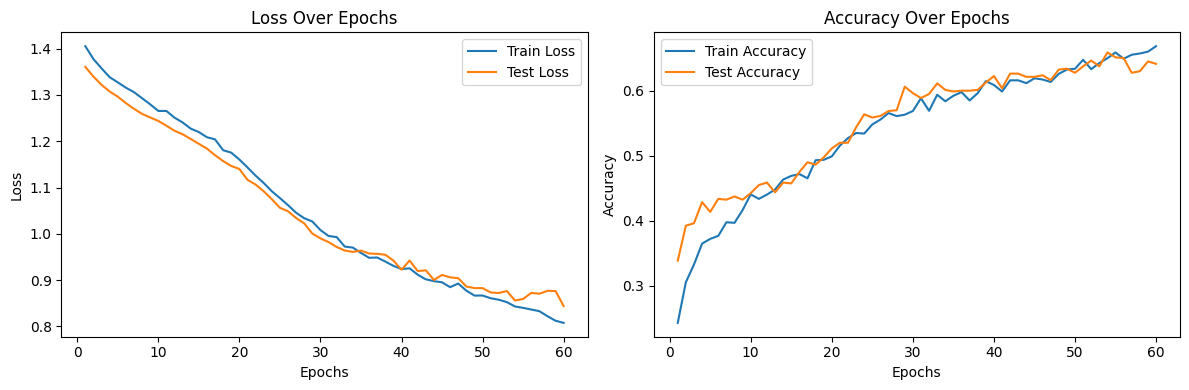

In [48]:
#Affichage des résultats
epochs = range(1, 60 + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[:60], label='Train Loss')
plt.plot(epochs, test_losses[:60], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies[:60], label='Train Accuracy')
plt.plot(epochs, test_accuracies[:60], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


In [ ]:
#Enregistrement du modèle
model_AlexNet = torch.save(AlexNet, 'AlexNet.pth')

In [ ]:
#Exportation des résultats
test_set = CustomImageDataset('train.csv', "/home/gris/N7/Semestre 8/Machine Learning/Projet Kaggle/modia-ml-2024/test/test", test=True)
test_loader = Data.DataLoader(test_set, batch_size=1, shuffle=False)

model_one.eval()
predictions = []

with torch.no_grad():
    for img in test_loader :
        img = img.to(device)
        output = model_one(img)
        predictions.append(torch.argmax(output).item())

fichier = pd.DataFrame({'id': np.array(range(len(predictions))) + 4000 , 'label': np.array(predictions) + 1})
fichier.to_csv('pred.csv', index=False)

## 4 - Machine learning and AI safety

##### Biased Dataset Construction

In [6]:
#On filtre les images de choux et choux-fleurs (on travaille maintenant sur 2 classes)
import pandas as pd
df_labels = pd.read_csv('train.csv')
df_labels_filtered = df_labels[df_labels['label'].isin([1,3])]
df_labels_filtered['label'] = df_labels_filtered['label'].replace({1:1, 3:2})
df_labels_filtered.to_csv('df_labels_filtered.csv', index=False)

/tmp/ipykernel_4659/2289195953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_filtered['label'] = df_labels_filtered['label'].replace({1:1, 3:2})


In [7]:
#On importe les données
data_filtered = CustomImageDataset('df_labels_filtered.csv', "train/train")
train_size = int(0.8 * len(data_filtered))
test_size = len(data_filtered) - train_size

train_dataset_f = Data.Subset(data_filtered, range(train_size))
test_dataset_f = Data.Subset(data_filtered, range(train_size, train_size + test_size))

trainloader_f = Data.DataLoader(train_dataset_f, batch_size=32, shuffle=False)
testloader_f = Data.DataLoader(test_dataset_f, batch_size=32, shuffle=False)

In [8]:
p0_train = 0
p1_train = 1
p0_test = 0.5
p1_test = 0.5

################################## Pre processing des données pour l'entrainement ####################################""

import torch
from torch.distributions import Normal
# Nouveau DataLoader pour les images avec le canal epsilon
dataloader_with_bias = []

# Paramètres de la distribution normale
mean = 0.0
std = 1.0

# Créer un objet de distribution normale
normal_distribution = Normal(mean, std)

for images, labels in trainloader_f:
    for i in range(len(labels)):
        image = images[i].unsqueeze(0)
        label = labels[i]
        if label.item() == 0:
            S = torch.bernoulli(torch.tensor([p0_train], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))
        if label.item() == 1:
            S = torch.bernoulli(torch.tensor([p1_train], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))

# Transformer la liste en TensorDataset
images_with_bias, labels_with_bias = zip(*dataloader_with_bias)
images_with_bias = torch.cat(images_with_bias, dim=0)
labels_with_bias = torch.tensor(labels_with_bias)
# Créer un DataLoader pour les images avec le canal epsilon
dataloader_with_bias_train = Data.DataLoader(list(zip(images_with_bias, labels_with_bias)), batch_size=32, shuffle=False)

################################## Pre processing des données pour le test ####################################

import torch
from torch.distributions import Normal
# Nouveau DataLoader pour les images avec le canal epsilon
dataloader_with_bias = []

# Paramètres de la distribution normale
mean = 0.0
std = 1.0

# Créer un objet de distribution normale
normal_distribution = Normal(mean, std)
S_list=[]

for images, labels in testloader_f:
    for i in range(len(labels)):
        image = images[i].unsqueeze(0)
        label = labels[i]
        if label.item() == 0:
            S = torch.bernoulli(torch.tensor([p0_test], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))
            S_list.append(S.item())
        if label.item() == 1:
            S = torch.bernoulli(torch.tensor([p1_test], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))
            S_list.append(S.item())

# Transformer la liste en TensorDataset
images_with_bias, labels_with_bias = zip(*dataloader_with_bias)
images_with_bias = torch.cat(images_with_bias, dim=0)
labels_with_bias = torch.tensor(labels_with_bias)
# Créer un DataLoader pour les images avec le canal epsilon
dataloader_with_bias_test = Data.DataLoader(list(zip(images_with_bias, labels_with_bias)), batch_size=32, shuffle=False)    

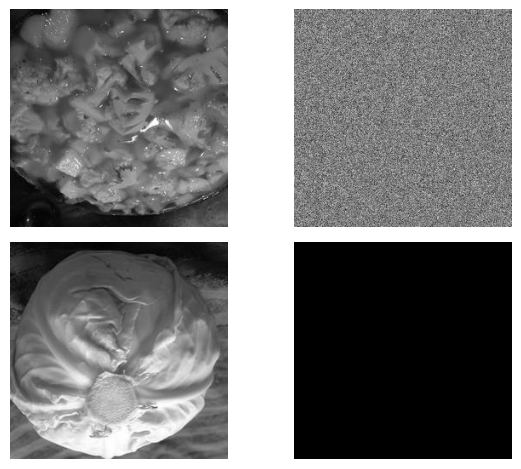

In [12]:
#Vérification que le préprocessing fonctionne
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

axs[0, 0].imshow(images_with_bias[0][0], cmap='gray')
axs[0, 0].axis('off')

axs[0, 1].imshow(images_with_bias[0][1], cmap='gray')
axs[0, 1].axis('off')

axs[1, 0].imshow(images_with_bias[1][0], cmap='gray')
axs[1, 0].axis('off')

axs[1, 1].imshow(images_with_bias[1][1], cmap='gray')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

##### Model Bias Evaluation

In [10]:
# Conception du modèle

import torch.nn as nn

class AlexNetWB(nn.Module):
    def __init__(self):
        super(AlexNetWB, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(2, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Flatten(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2)
            )
        
    def forward(self, x):
        return self.network(x)

In [11]:
#Entrainement du modèle pour p0_train = 0 et p1_train = 1
from sklearn.metrics import accuracy_score
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10

model_one = AlexNetWB()
model_one.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_one.parameters(), lr=1e-4) 

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model_one.train()  
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for inputs, label in tqdm(dataloader_with_bias_train):
        inputs, label = inputs.to(device).float(), label.to(device)
        optimizer.zero_grad()
        outputs = model_one(inputs)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        running_loss += loss.item()

    train_losses.append(running_loss / len(dataloader_with_bias_train))
    train_accuracies.append(accuracy_score(all_labels, all_predictions))

    model_one.eval() 
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, label in dataloader_with_bias_test:
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model_one(inputs)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            running_loss += loss.item()

    test_losses.append(running_loss / len(dataloader_with_bias_test))
    test_accuracies.append(accuracy_score(all_labels, all_predictions))
    
    print(f'Fin epoch: {epoch + 1}/{num_epochs} - Accuracy de train: {train_accuracies[-1]:.4f} - Accuracy de test: {test_accuracies[-1]:.4f}')


100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


Fin epoch: 1/10 - Accuracy de train: 0.7140 - Accuracy de test: 0.5013


100%|██████████| 50/50 [00:04<00:00, 12.20it/s]


Fin epoch: 2/10 - Accuracy de train: 0.8643 - Accuracy de test: 0.4987


100%|██████████| 50/50 [00:04<00:00, 12.12it/s]


Fin epoch: 3/10 - Accuracy de train: 0.9615 - Accuracy de test: 0.4962


100%|██████████| 50/50 [00:04<00:00, 12.18it/s]


Fin epoch: 4/10 - Accuracy de train: 0.9937 - Accuracy de test: 0.4962


100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


Fin epoch: 5/10 - Accuracy de train: 0.9943 - Accuracy de test: 0.4962


100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


Fin epoch: 6/10 - Accuracy de train: 0.9975 - Accuracy de test: 0.4962


100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


Fin epoch: 7/10 - Accuracy de train: 0.9994 - Accuracy de test: 0.4962


100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


Fin epoch: 8/10 - Accuracy de train: 0.9987 - Accuracy de test: 0.4962


100%|██████████| 50/50 [00:04<00:00, 12.15it/s]


Fin epoch: 9/10 - Accuracy de train: 1.0000 - Accuracy de test: 0.4962


100%|██████████| 50/50 [00:04<00:00, 12.10it/s]


Fin epoch: 10/10 - Accuracy de train: 0.9994 - Accuracy de test: 0.4962


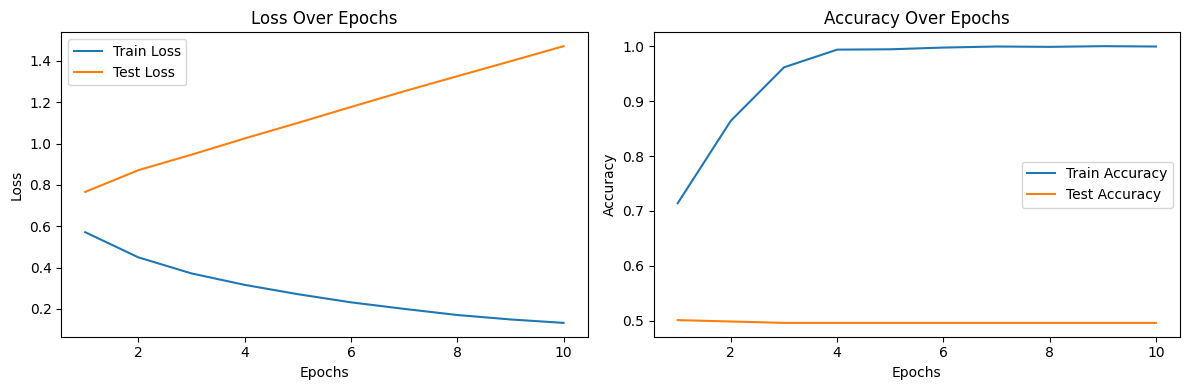

In [12]:
#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

Analyse : Pas d'augmentation de l'accuracy de test qui est constante autour de 0.5. L'accuracy de train elle, atteint 1 très rapidement. La loss de test est donc strictement croissante et celle du test converge. Le modèle biaisé n'est donc pas du tout performant, ce qui est cohérent.

In [13]:
# Calcul du DI
model_one.eval()
predictions = []

with torch.no_grad():
    for img, _ in dataloader_with_bias_test:  # Le second élément est S, pas les labels
        img = img.to(device)
        output = model_one(img)
        
        # Obtenir les prédictions pour chaque image dans le batch
        preds = torch.argmax(output, dim=1).cpu().numpy()
        predictions.extend(preds.tolist()) #extrait le tenseur 


# Création du DataFrame avec les prédictions et les valeurs de S
df = pd.DataFrame({'prediction': predictions, 'S': S_list})

# Filtrer le DataFrame pour obtenir les valeurs correspondantes
B = df[(df['prediction'] == 1) & (df['S'] == 0)].shape[0]  # Nombre de lignes où prediction=1 et S=0
A = df[(df['prediction'] == 1) & (df['S'] != 0)].shape[0]  # Nombre de lignes où prediction=1 et S!=0

# Calcul du DI
DI = B / A
print(f"Disparate Impact (DI): {DI}")


Disparate Impact (DI): 0.0


### Analyse

Le Disparate Impact (DI) est un indicateur crucial pour évaluer le biais dans un modèle de classification. Le calcul du DI nous permet de quantifier l'impact des caractéristiques sensibles (comme le biais) sur les prédictions du modèle. 

Dans notre cas, nous avons défini les probabilités `p0_test` et `p1_test` pour générer les valeurs de biais `S`. Ces valeurs influencent la manière dont les images sont traitées par le modèle.

1. **Interprétation de A et B** :
   - **A** : Nombre de prédictions égales à 1 pour lesquelles `S` est différent de 0.
   - **B** : Nombre de prédictions égales à 1 pour lesquelles `S` est égal à 0.

2. **Signification du ratio B/A** :
   - **Si A est proche de 0** : Cela indique que le modèle est fortement biaisé. Dans ce scénario, la plupart des prédictions de 1 sont associées à `S = 0`, ce qui montre une dépendance marquée du modèle à la valeur de `S`.
   - **Si A est proche de 1** : Cela signifie que le modèle est non biaisé. Les prédictions de 1 ne dépendent pas significativement des valeurs de `S`, indiquant une neutralité du modèle vis-à-vis du biais.

3. **Observations** :
   - Nous avons observé un DI de 0, ce qui est cohérent avec notre hypothèse. En se plaçant dans le cas extrême où les valeurs de `p0` et `p1` sont choisies pour introduire un biais complet, le modèle répond comme prévu.
   - Les valeurs de `p0` et `p1` ont été définies de manière à créer un modèle complètement biaisé. Cela signifie que le modèle dépend fortement de `S` pour ses prédictions, ce qui est reflété par un DI de 0.

En conclusion, notre analyse montre que le modèle est biaisé, ce qui est en accord avec les valeurs extrêmes de `p0` et `p1` utilisées. Pour obtenir un modèle non biaisé, il serait nécessaire de réévaluer ces probabilités et de retravailler sur l'entraînement du modèle afin de réduire la dépendance aux valeurs de `S`.

#### Avec d'autres valeurs de p0 et p1

In [20]:
p0_train = 0.5
p1_train = 0.5
p0_test = 0.5
p1_test = 0.5

################################## Pre processing des données pour l'entrainement ####################################""

import torch
from torch.distributions import Normal
# Nouveau DataLoader pour les images avec le canal epsilon
dataloader_with_bias = []

# Paramètres de la distribution normale
mean = 0.0
std = 1.0

# Créer un objet de distribution normale
normal_distribution = Normal(mean, std)

for images, labels in trainloader_f:
    for i in range(len(labels)):
        image = images[i].unsqueeze(0)
        label = labels[i]
        if label.item() == 0:
            S = torch.bernoulli(torch.tensor([p0_train], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))
        if label.item() == 1:
            S = torch.bernoulli(torch.tensor([p1_train], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))

# Transformer la liste en TensorDataset
images_with_bias, labels_with_bias = zip(*dataloader_with_bias)
images_with_bias = torch.cat(images_with_bias, dim=0)
labels_with_bias = torch.tensor(labels_with_bias)
# Créer un DataLoader pour les images avec le canal epsilon
dataloader_with_bias_train = Data.DataLoader(list(zip(images_with_bias, labels_with_bias)), batch_size=32, shuffle=False)

################################## Pre processing des données pour le test ####################################

import torch
from torch.distributions import Normal
# Nouveau DataLoader pour les images avec le canal epsilon
dataloader_with_bias = []

# Paramètres de la distribution normale
mean = 0.0
std = 1.0

# Créer un objet de distribution normale
normal_distribution = Normal(mean, std)
S_list=[]

for images, labels in testloader_f:
    for i in range(len(labels)):
        image = images[i].unsqueeze(0)
        label = labels[i]
        if label.item() == 0:
            S = torch.bernoulli(torch.tensor([p0_test], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))
            S_list.append(S.item())
        if label.item() == 1:
            S = torch.bernoulli(torch.tensor([p1_test], dtype=torch.float))  # Générer un échantillon par image
            if S.item() == 0:
                bias = torch.zeros(1, image.shape[1], image.shape[2], image.shape[3])
            else:
                bias = normal_distribution.sample((1, image.shape[1], image.shape[2], image.shape[3]))
            image_with_bias = torch.cat((image, bias), dim=1)
            dataloader_with_bias.append((image_with_bias, label))
            S_list.append(S.item())

# Transformer la liste en TensorDataset
images_with_bias, labels_with_bias = zip(*dataloader_with_bias)
images_with_bias = torch.cat(images_with_bias, dim=0)
labels_with_bias = torch.tensor(labels_with_bias)
# Créer un DataLoader pour les images avec le canal epsilon
dataloader_with_bias_test = Data.DataLoader(list(zip(images_with_bias, labels_with_bias)), batch_size=32, shuffle=False)    

In [21]:
#Entrainement du modèle pour p0_train = 0.5 et p1_train = 0.5
from sklearn.metrics import accuracy_score
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 10

model_one = AlexNetWB()
model_one.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_one.parameters(), lr=1e-5)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model_one.train()  
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for inputs, label in tqdm(dataloader_with_bias_train):
        inputs, label = inputs.to(device).float(), label.to(device)
        optimizer.zero_grad()
        outputs = model_one(inputs)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        predicted = outputs.argmax(dim=1)
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        running_loss += loss.item()

    train_losses.append(running_loss / len(dataloader_with_bias_train))
    train_accuracies.append(accuracy_score(all_labels, all_predictions))

    model_one.eval()  
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, label in dataloader_with_bias_test:
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model_one(inputs)
            loss = criterion(outputs, label)

            predicted = outputs.argmax(dim=1)
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            running_loss += loss.item()

    test_losses.append(running_loss / len(dataloader_with_bias_test))
    test_accuracies.append(accuracy_score(all_labels, all_predictions))
    
    print(f'Fin epoch: {epoch + 1}/{num_epochs} - Loss de train: {train_losses[-1]:.4f} - Accuracy de train: {train_accuracies[-1]:.4f} - Loss de test: {test_losses[-1]:.4f} - Accuracy de test: {test_accuracies[-1]:.4f}')


100%|██████████| 50/50 [00:05<00:00,  8.79it/s]


Fin epoch: 1/10 - Loss de train: 0.7151 - Accuracy de train: 0.5177 - Loss de test: 0.7308 - Accuracy de test: 0.4912


100%|██████████| 50/50 [00:05<00:00,  8.76it/s]


Fin epoch: 2/10 - Loss de train: 0.7012 - Accuracy de train: 0.5372 - Loss de test: 0.7347 - Accuracy de test: 0.4912


100%|██████████| 50/50 [00:05<00:00,  8.75it/s]


Fin epoch: 3/10 - Loss de train: 0.7049 - Accuracy de train: 0.5625 - Loss de test: 0.7367 - Accuracy de test: 0.4912


100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


Fin epoch: 4/10 - Loss de train: 0.6849 - Accuracy de train: 0.5720 - Loss de test: 0.7376 - Accuracy de test: 0.4937


100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


Fin epoch: 5/10 - Loss de train: 0.6750 - Accuracy de train: 0.5947 - Loss de test: 0.7517 - Accuracy de test: 0.4937


100%|██████████| 50/50 [00:05<00:00,  8.71it/s]


Fin epoch: 6/10 - Loss de train: 0.6621 - Accuracy de train: 0.6029 - Loss de test: 0.7117 - Accuracy de test: 0.5164


100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


Fin epoch: 7/10 - Loss de train: 0.6387 - Accuracy de train: 0.6345 - Loss de test: 0.7018 - Accuracy de test: 0.5164


100%|██████████| 50/50 [00:05<00:00,  8.74it/s]


Fin epoch: 8/10 - Loss de train: 0.6076 - Accuracy de train: 0.6749 - Loss de test: 0.6726 - Accuracy de test: 0.5718


100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


Fin epoch: 9/10 - Loss de train: 0.5719 - Accuracy de train: 0.6963 - Loss de test: 0.6763 - Accuracy de test: 0.5542


100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


Fin epoch: 10/10 - Loss de train: 0.5088 - Accuracy de train: 0.7588 - Loss de test: 0.6709 - Accuracy de test: 0.5743


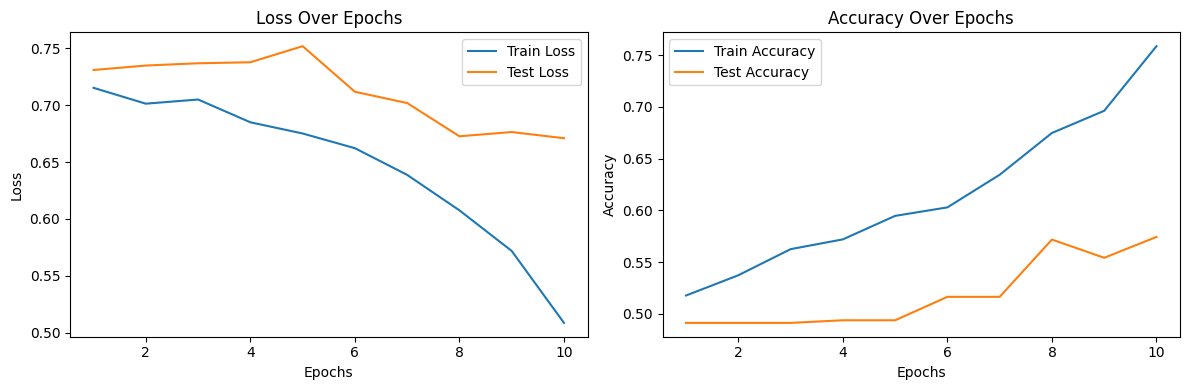

In [22]:
#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

In [23]:
# Calcul du DI
model_one.eval()
predictions = []

with torch.no_grad():
    for img, _ in dataloader_with_bias_test:  # Le second élément est S, pas les labels
        img = img.to(device)
        output = model_one(img)
        
        # Obtenir les prédictions pour chaque image dans le batch
        preds = torch.argmax(output, dim=1).cpu().numpy()
        predictions.extend(preds.tolist()) #extrait le tenseur 

  
# Création du DataFrame avec les prédictions et les valeurs de S
df_2 = pd.DataFrame({'prediction': predictions, 'S': S_list})

# Filtrer le DataFrame pour obtenir les valeurs correspondantes
B = df_2[(df_2['prediction'] == 1) & (df_2['S'] == 0)].shape[0]  # Nombre de lignes où prediction=1 et S=0
A = df_2[(df_2['prediction'] == 1) & (df_2['S'] != 0)].shape[0]  # Nombre de lignes où prediction=1 et S!=0

# Calcul du Disparate Impact (DI)
DI = B / A
print(f"Disparate Impact (DI): {DI}")


Disparate Impact (DI): 0.84375


Avec p0train = 0.5 p0train​=0.5 et p1train=0.5 p1train​=0.5, j'ai introduit un biais symétrique dans les données d'entraînement. De même, les valeurs p0test=0.5p0test​=0.5 et p1test=0.5p1test​=0.5 maintiennent ce biais symétrique dans les données de test. Le modèle est donc exposé à une distribution biaisée où chaque classe a une probabilité égale d'introduire un bruit gaussien.

La valeur de DI de 0.84375 indique que le biais est désormais très léger comparé à précédemment.

##### Modèle non biaisé

In [24]:
# Conception du modèle

import torch.nn as nn

class AlexNetSB(nn.Module):
    def __init__(self):
        super(AlexNetSB, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2), 
            nn.Flatten(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 2)
            )
        
    def forward(self, x):
        return self.network(x)

In [43]:
#Entrainement du modèle
from sklearn.metrics import accuracy_score
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
   
model_SB = AlexNetSB()
model_SB.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_SB.parameters(), lr=1e-5, weight_decay=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses = []
test_losses = []
train_accuracies = [] 
test_accuracies = []

for epoch in range(num_epochs):
    model_SB.train() 
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for inputs, label in tqdm(trainloader_f):
        inputs, label = inputs.to(device).float(), label.to(device)
        optimizer.zero_grad()
        outputs = model_SB(inputs)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        running_loss += loss.item()
  
    train_losses.append(running_loss / len(trainloader_f))
    train_accuracies.append(accuracy_score(all_labels, all_predictions))

    model_SB.eval() 
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, label in testloader_f:
            inputs, label = inputs.to(device).float(), label.to(device)
            outputs = model_SB(inputs)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            running_loss += loss.item()

    test_losses.append(running_loss / len(testloader_f))
    test_accuracies.append(accuracy_score(all_labels, all_predictions))
    print(f'Fin epoch: {epoch + 1}/{num_epochs} - Accuracy de train: {train_accuracies[-1]:.4f} - Accuracy de test: {test_accuracies[-1]:.4f}')
    
    scheduler.step()

print('Entraînement terminé')


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Fin epoch: 1/25 - Accuracy de train: 0.5114 - Accuracy de test: 0.4912


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Fin epoch: 2/25 - Accuracy de train: 0.5145 - Accuracy de test: 0.5063


100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Fin epoch: 3/25 - Accuracy de train: 0.5316 - Accuracy de test: 0.5164


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Fin epoch: 4/25 - Accuracy de train: 0.5410 - Accuracy de test: 0.5189


100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Fin epoch: 5/25 - Accuracy de train: 0.5644 - Accuracy de test: 0.5189


100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Fin epoch: 6/25 - Accuracy de train: 0.5827 - Accuracy de test: 0.5617


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Fin epoch: 7/25 - Accuracy de train: 0.5795 - Accuracy de test: 0.5642


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Fin epoch: 8/25 - Accuracy de train: 0.5821 - Accuracy de test: 0.5844


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Fin epoch: 9/25 - Accuracy de train: 0.6206 - Accuracy de test: 0.5793


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Fin epoch: 10/25 - Accuracy de train: 0.6124 - Accuracy de test: 0.6045


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Fin epoch: 11/25 - Accuracy de train: 0.6433 - Accuracy de test: 0.6297


100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


Fin epoch: 12/25 - Accuracy de train: 0.6616 - Accuracy de test: 0.6222


100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Fin epoch: 13/25 - Accuracy de train: 0.6389 - Accuracy de test: 0.6373


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Fin epoch: 14/25 - Accuracy de train: 0.6452 - Accuracy de test: 0.6348


100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Fin epoch: 15/25 - Accuracy de train: 0.6471 - Accuracy de test: 0.6348


100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Fin epoch: 16/25 - Accuracy de train: 0.6484 - Accuracy de test: 0.6499


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Fin epoch: 17/25 - Accuracy de train: 0.6635 - Accuracy de test: 0.6423


100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Fin epoch: 18/25 - Accuracy de train: 0.6831 - Accuracy de test: 0.6524


100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Fin epoch: 19/25 - Accuracy de train: 0.6629 - Accuracy de test: 0.6524


100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Fin epoch: 20/25 - Accuracy de train: 0.6585 - Accuracy de test: 0.6499


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Fin epoch: 21/25 - Accuracy de train: 0.6679 - Accuracy de test: 0.6574


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Fin epoch: 22/25 - Accuracy de train: 0.6591 - Accuracy de test: 0.6474


100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Fin epoch: 23/25 - Accuracy de train: 0.6610 - Accuracy de test: 0.6599


100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Fin epoch: 24/25 - Accuracy de train: 0.6641 - Accuracy de test: 0.6499


100%|██████████| 50/50 [00:07<00:00,  6.90it/s]


Fin epoch: 25/25 - Accuracy de train: 0.6875 - Accuracy de test: 0.6448
Entraînement terminé


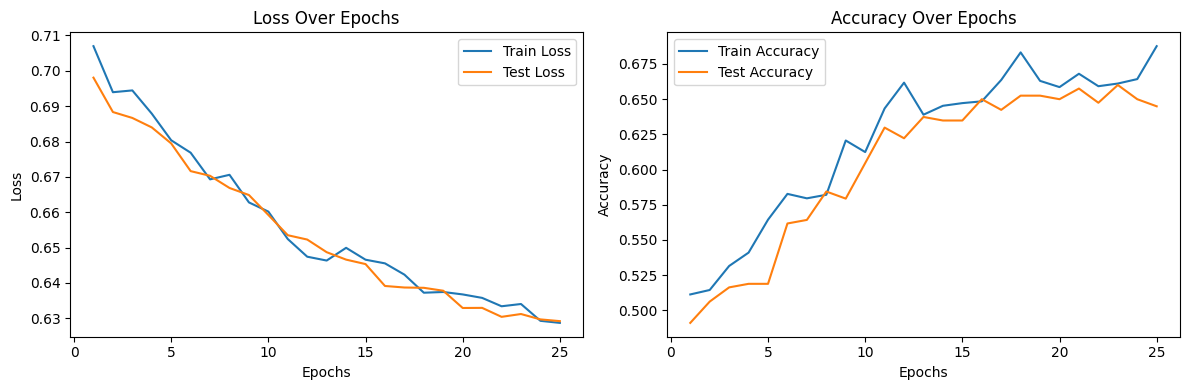

In [44]:
#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')  
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.title('Loss Over Epochs')
  
plt.subplot(1, 2, 2)   
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

Les résultats de l'entraînement de mon modèle montrent une performance encourageante. Au fil des 30 époques, les loss de train et de test ont diminué de manière significative, indiquant que le modèle s'ajuste bien aux données et que le risque de surapprentissage est faible. En parallèle, les accuracy pour les ensembles de données d'entraînement et de test ont augmenté régulièrement pour se stabiliser autour de 0.675. Cette convergence démontre que le modèle a atteint une bonne capacité de généralisation, ce qui signifie qu'il est capable de faire des prédictions précises.